# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Находнов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ L(\overline{\beta}, X, \overline{y}) = \sum\limits_{i = 1}^{m}[y^{i}=1]\log({\sigma(\overline{x}\overline{\beta})}) + [y^{i}=-1]\log({1-\sigma(\overline{x}^{i}\overline{\beta})}) + \frac{1}{C}\sum\limits_{j=1}^{n}\beta_{j}^{2}$$

Вектор-целевая переменная:
$$ \overline{y} = (y^{1}, \dots, y^{m})^{T} , y^{j} \in \{1, -1\} \forall 1 \le j \le m$$ 

Вектор параметров модели:
$$ \overline{\beta} = (\beta_{0}, \beta_{1}, \dots, \beta_{n})^{T}$$

Вектора-события:
$$ X = \begin{bmatrix}
            x_{0}^{1} & x_{1}^{1} & \dots & x_{n}^{1} \\
            x_{0}^{2} & x_{1}^{2} & \dots & x_{n}^{2} \\
               \dots  &   \dots   & \dots &    \dots  \\
            x_{0}^{m} & x_{1}^{m} & \dots & x_{n}^{m} \\
        \end{bmatrix}
\overline{x}^{i} = (x_{0}^{j}, \dots, x_{n}^{j}); x_{0}^{j} = 1  \forall  1 \leq i \leq m$$

Сигмоида отступа:
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

Тогда градиент:
$$ \frac{\partial L}{\partial{\overline{\beta}}} = \frac{1}{m}X^{T}\overline{\gamma} + \frac{2}{C}\hat{\overline{\beta}} $$

Где:
$$ \hat{\overline{\beta}} : \hat{\beta}_{j} = 
\begin{equation*}
 \begin{cases}
   \beta_{j}, 0 < j \le n
   \\
   0, j = 0
 \end{cases}
\end{equation*}
$$

$$ \overline{\gamma} = \{\gamma^{j} : \gamma^{j} = -\frac{y^{j}}{1 + e^{y^{j}\overline{x}^{j}\overline{\beta}}}\}_{j=1}^{m} $$

## Имплементация (5 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=100, verbose=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.verbose = verbose
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        # Проверяем количество различных классов в исходных данных  
        y_diff = np.unique(y)
        if y_diff.size > 2:
            return self
        # Выставляем номера классов 1, -1
        y_pr = y.copy()
        y_pr[y == y_diff[0]] = -1
        y_pr[y == y_diff[1]] = 1
        
        # Добавляем фиктивную координату для свободного члена
        X_pr = np.c_[np.ones(X.shape[0]), X]
        #X_pr.astype(np.float64)
        
        # Устанавливаем начальные значения коэффициентам регрессии
        self.betas = np.ones(X_pr.shape[1], dtype=np.float64)
        
        # Начальные знаачения индексов для разбиения на батчи
        indixes = np.arange(X_pr.shape[0])
        
        self.errors = []
        
        # Цикл пересчёта коэффициентов регрессии
        for epoch in xrange(self.max_epoch):
            # Выбор индексов для батчей
            np.random.shuffle(indixes)
            batch_indixes = np.array_split(indixes, indixes.shape[0] / self.batch_size)
            # Для каждого батча считаем градиент и пересчитываем коэффициенты регрессии
            for batch_numer, batch in enumerate(batch_indixes):
                gammas = - y_pr / (1 + np.exp(y_pr * X_pr.dot(self.betas)))
                grad = (1.0 / X_pr.shape[0]) * X_pr.T.dot(gammas) + (2.0 / self.C) * np.append(np.array([0]),self.betas[1:])
                self.betas = self.betas - self.alpha * grad / (epoch + 1.0)
                if self.verbose:
                    print 'batch %d ends' % batch_numer
                
            # Запоминаем ошибку на каждой итерации
            error = (1.0 / X_pr.shape[0]) * np.sum(np.log(1 + np.exp(-y_pr * X_pr.dot(self.betas))))
            self.errors.append(error)
            if self.verbose:
                print 'epoch %d ends' % epoch
            
        self.errors = np.array(self.errors)            
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X_pr = np.c_[np.ones(X.shape[0]), X]
        return X_pr.dot(self.betas) > 0
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X_pr = np.c_[np.ones(X.shape[0]), X]
        plus_proba = 1 / (1 + np.exp(X_pr.dot(self.betas)))
        return  np.c_[plus_proba, 1 - plus_proba]

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [4]:
from sklearn.linear_model import LogisticRegression

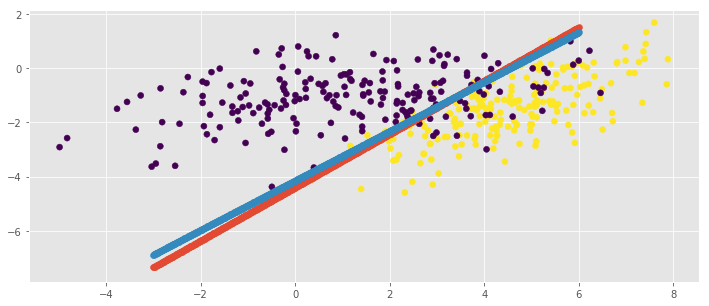

In [5]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X_snt = np.vstack([gauss1, gauss2])
y_snt = np.r_[np.ones(200), np.zeros(200)]
#y_snt[X_snt.dot(np.array([3, 4])) - 1.8 > 0] = 1
#y_snt[X_snt.dot(np.array([3, 4])) - 1.8 <= 0] = -1


sk_snt = LogisticRegression(max_iter=1000)
sk_snt.fit(X_snt, y_snt)

my_snt = MySGDClassifier(max_epoch=100, alpha=3, batch_size=40, C=100)
my_snt.fit(X_snt, y_snt)

plt.scatter(X_snt[:,0], X_snt[:,1], c=y_snt)#c=my_snt.predict_proba(X_snt)[:, 0])
X0_dot = np.linspace(-3, 6, 1000)
plt.scatter(X0_dot, -(my_snt.betas[0] + my_snt.betas[1] * X0_dot) / my_snt.betas[2])
plt.scatter(X0_dot, -(sk_snt.intercept_ + sk_snt.coef_[0][0] * X0_dot) / sk_snt.coef_[0][1])

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [6]:
from sklearn.datasets import make_classification

In [7]:
X_cnv, y_cnv = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

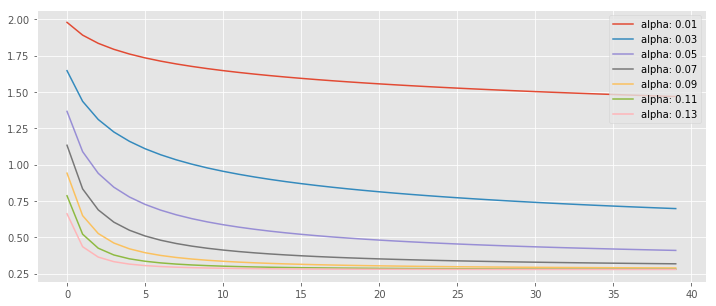

In [8]:
for alpha in np.arange(0.01, 0.15, 0.02):
    my_cnv = MySGDClassifier(alpha=alpha, C=5.0, max_epoch=40, batch_size=X_cnv.shape[0]/10)
    my_cnv.fit(X_cnv, y_cnv)
    plt.plot(np.arange(my_cnv.errors.shape[0]), my_cnv.errors, label='alpha: {}'.format(alpha))
plt.legend()

Как и ожидалось, с каждой следующей итерацией ошибка убывает, и, с некого момента выходит на плато, что означает, что алгоритм сошёлся.

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_cnv_train, X_cnv_test, y_cnv_train, y_cnv_test = train_test_split(X_cnv, y_cnv, test_size = 0.2, random_state=42)
rc_c = MySGDClassifier(max_epoch=40, batch_size=X_cnv_train.shape[0]/10, alpha=1)
rc_c.fit(X_cnv_train, y_cnv_train)

print 'ROC_AUC:', roc_auc_score(y_cnv_test, rc_c.predict(X_cnv_test))

ROC_AUC: 0.959114291099


## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [10]:
## Your Code Here
coefs = np.empty((len(np.logspace(3, -3, 10)), X_cnv.shape[1] + 1))
for i, c in enumerate(np.logspace(3, -3, 10)):
    my_rg = MySGDClassifier(alpha=2, max_epoch=50, C=c, batch_size=X_cnv.shape[0]/30)
    my_rg.fit(X_cnv, y_cnv)
    coefs[i] = my_rg.betas

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in multiply


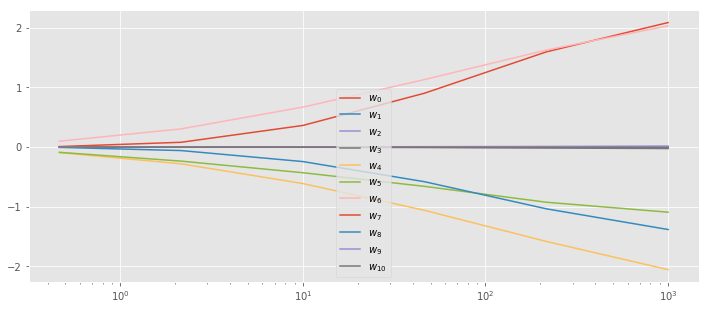

In [11]:
for it in range(X_cnv.shape[1] + 1):   
    plt.plot(np.logspace(3, -3, 10)[0:6], coefs[:, it][0:6], label='$w_{%d}$' % it)
    plt.xscale('log')
plt.legend()

 Данная диаграмма показывает, что с увеличением C влияние на регуляризацию уменьшается и, как следствие, величины коэффициентов начинают возрастать.    
 Нужно заметить, что при разничных параметрах alpha и C начинают появляться различные ошибки переполнения. Это связано с тем, что по-началу, величины предсказания моделью $\overline{x}^{i}\overline{\beta} << 0 \Rightarrow{} e^{\overline{x}^{i}\overline{\beta}} >> 0 \Rightarrow $ происходит переполнение.

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [231]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [232]:
df_data.shape

(2000000, 45)

In [233]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [234]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [235]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50479949999999996

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [236]:
## Youd Code Here
print np.sort(df_data.opponent_hero_card_id.unique())
print np.sort(df_data.player_hero_card_id.unique())

[  25  326  390  494  612  754  798  981 1235]
[  25  326  390  494  612  754  798  981 1235]


In [237]:
from sklearn.preprocessing import OneHotEncoder

In [238]:
encoder_opp = OneHotEncoder()
encoder_pla = OneHotEncoder()

In [239]:
encoder_opp.fit(df_data.loc[:, ['opponent_hero_card_id']])
encoder_pla.fit(df_data.loc[:, ['player_hero_card_id']])

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [240]:
opp_enc = encoder_opp.transform(df_data.loc[:, ['opponent_hero_card_id']])
pla_enc = encoder_pla.transform(df_data.loc[:, ['player_hero_card_id']])

In [241]:
df_data_prep = df_data.drop(['opponent_hero_card_id', 'player_hero_card_id', 'decision'], axis=1)

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [242]:
X_real = np.c_[df_data_prep.values, opp_enc.toarray(), pla_enc.toarray()]
y_real = df_data.decision.values

In [243]:
## Youd Code Here
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



Применение и обучение можели смотрите далее.

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [335]:
## Youd Code Here
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real[:200000], y_real[:200000], test_size = 0.3, random_state=42)

my_pipe = Pipeline(steps=[('scalling', StandardScaler()),
                          ('logreg', MySGDClassifier(max_epoch=60,\
                                                     C=3, alpha=0.7,\
                                                     batch_size=X_real_train.shape[0]/11))])
                                  
my_pipe.fit(X_real_train, y_real_train)
print 'ROC_AUC:', roc_auc_score(y_real_test, my_pipe.predict(X_real_test))

ROC_AUC: 0.680224220864
